### Imports

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
from datetime import datetime
from scipy.stats import norm

/Users/aayushkhandekar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Get NVDA Data - stock and options

expiration date = 2025-08-01

In [2]:
ticker = yf.Ticker('NVDA')

expiration_date = '2025-08-01'

options = ticker.option_chain(expiration_date)

calls = options.calls

puts = options.puts

calls['Option'] = 'C'

puts['Option'] = 'P'

options = pd.concat(objs=[calls, puts], ignore_index=True)

### Black-Scholes Model

- We use BSM to understand, compare and make decisions based on the prices calculated.

- The market can be distorted due to various reasons which is why we calculate the fair theoretical fair price for the options and make our comparisons.

- We can calculate the implied volatility using the market price of the option with the help of BSM.

In [3]:
class BlackScholesModel:

    def __init__(self):
        pass

    def d1(self, S0, K, T, r, sigma):
        return (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    
    def d2(self, S0, K, T, r, sigma):
        return self.d1(S0, K, T, r, sigma) - (sigma * np.sqrt(T))
    
    def call_price(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        d2 = self.d2(S0, K, T, r, sigma)
        return (S0 * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
    
    def put_price(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        d2 = self.d2(S0, K, T, r, sigma)
        return (-S0 * norm.cdf(-d1)) + (K * np.exp(-r * T) * norm.cdf(-d2))

bsm = BlackScholesModel()

In [4]:
options.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option
0,NVDA250801C00020000,2025-07-10 19:54:31+00:00,20.0,144.15,0.0,0.0,0.0,0.0,3.0,0,0.00001,True,REGULAR,USD,C
1,NVDA250801C00055000,2025-07-02 19:50:00+00:00,55.0,102.55,0.0,0.0,0.0,0.0,1.0,0,0.00001,True,REGULAR,USD,C
2,NVDA250801C00065000,2025-06-25 18:01:46+00:00,65.0,88.15,0.0,0.0,0.0,0.0,NaN,0,0.00001,True,REGULAR,USD,C
3,NVDA250801C00075000,2025-07-01 19:40:06+00:00,75.0,78.93,0.0,0.0,0.0,0.0,7.0,0,0.00001,True,REGULAR,USD,C
4,NVDA250801C00080000,2025-07-07 13:51:52+00:00,80.0,79.21,0.0,0.0,0.0,0.0,4.0,0,0.00001,True,REGULAR,USD,C


In [5]:
today_date = datetime.strptime(date.today().strftime("%Y-%m-%d"), "%Y-%m-%d") 
expiration_date = datetime.strptime(expiration_date, "%Y-%m-%d")
days_to_expiry = (expiration_date - today_date).days
days_to_expiry

21

In [6]:
r = 0.05
T = T = days_to_expiry/365
S0 = ticker.history(period='1d')['Close'].iloc[-1]

def theoretical_option_price(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    if row['Option'] == 'C':
        return bsm.call_price(S0, K, T, r, sigma)
    return bsm.put_price(S0, K, T, r, sigma)

options['theoreticalPriceBSM'] = options.apply(theoretical_option_price, axis=1)

### Greeks

- Delta: Change in option price relative to a $1 move in the underlying [-1,1]

- Gamma: Change in delta as the underlying price changes

- Vega

- Theta

In [7]:
class OptionGreeks:
    
    def __init__(self):
        pass

    def d1(self, S0, K, T, r, sigma):
        return (np.log(S0 / K) + (r + 0.5 * (sigma ** 2)) * T) / (sigma * np.sqrt(T))
    
    def d2(self, S0, K, T, r, sigma):
        return self.d1(S0, K, T, r, sigma) - (sigma * np.sqrt(T))
    
    def delta(self, S0, K, T, r, sigma, option_type):
        d1 = self.d1(S0, K, T, r, sigma)
        if option_type == 'C':
            return norm.cdf(d1)
        return norm.cdf(d1) - 1
    
    def gamma(self, S0, K, T, r, sigma):
        d1 = self.d1(S0, K, T, r, sigma)
        return norm.pdf(d1) / (S0 * sigma * np.sqrt(T))

og = OptionGreeks()

def option_delta(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    option_type = row['Option']
    return og.delta(S0, K, T, r, sigma, option_type)

def option_gamma(row):
    K = row['strike']
    sigma = row['impliedVolatility']
    return og.gamma(S0, K, T, r, sigma)

options['delta'] = options.apply(option_delta, axis=1) 

options['gamma'] = options.apply(option_gamma, axis=1) 
    

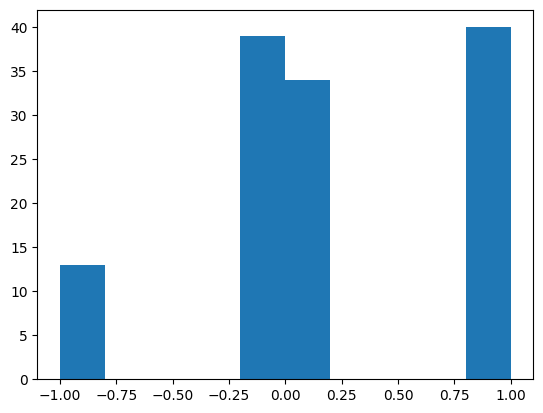

In [8]:
import matplotlib.pyplot as plt

plt.hist(options['delta'])
plt.show()

In [9]:
options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Option,theoreticalPriceBSM,delta,gamma
0,NVDA250801C00020000,2025-07-10 19:54:31+00:00,20.0,144.15,0.0,0.0,0.0,0.0,3.0,0,0.00001,True,REGULAR,USD,C,144.157458,1.0,0.0
1,NVDA250801C00055000,2025-07-02 19:50:00+00:00,55.0,102.55,0.0,0.0,0.0,0.0,1.0,0,0.00001,True,REGULAR,USD,C,109.257998,1.0,0.0
2,NVDA250801C00065000,2025-06-25 18:01:46+00:00,65.0,88.15,0.0,0.0,0.0,0.0,NaN,0,0.00001,True,REGULAR,USD,C,99.286724,1.0,0.0
3,NVDA250801C00075000,2025-07-01 19:40:06+00:00,75.0,78.93,0.0,0.0,0.0,0.0,7.0,0,0.00001,True,REGULAR,USD,C,89.315449,1.0,0.0
4,NVDA250801C00080000,2025-07-07 13:51:52+00:00,80.0,79.21,0.0,0.0,0.0,0.0,4.0,0,0.00001,True,REGULAR,USD,C,84.329812,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,NVDA250801P00185000,2025-07-10 19:09:26+00:00,185.0,21.42,0.0,0.0,0.0,0.0,6.0,0,0.00001,True,REGULAR,USD,P,20.368567,-1.0,0.0
122,NVDA250801P00187500,2025-07-02 16:25:55+00:00,187.5,30.15,0.0,0.0,0.0,0.0,NaN,0,0.00001,True,REGULAR,USD,P,22.861385,-1.0,0.0
123,NVDA250801P00190000,2025-07-10 18:00:45+00:00,190.0,26.00,0.0,0.0,0.0,0.0,4.0,0,0.00001,True,REGULAR,USD,P,25.354204,-1.0,0.0
124,NVDA250801P00192500,2025-06-27 15:24:25+00:00,192.5,34.65,0.0,0.0,0.0,0.0,4.0,0,0.00001,True,REGULAR,USD,P,27.847023,-1.0,0.0


(array([125.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.        , 0.04993806, 0.09987613, 0.14981419, 0.19975226,
        0.24969032, 0.29962839, 0.34956645, 0.39950452, 0.44944258,
        0.49938065]),
 <BarContainer object of 10 artists>)

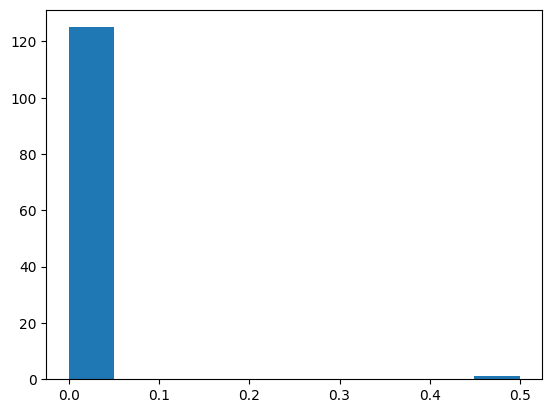

In [10]:
plt.hist(options['gamma'])